##Machine Translation Using a Seq2Seq Architecture
© 2023, Zaka AI, Inc. All Rights Reserved.

---
The goal of this colab is to get you more familiar with the Seq2Seq models and their challenges. For this reason, you will be working on machine translation problem where we would have a sentence as input (in english), and the output is gonna be the translated sentence (in french). So just like what happens with Google Translate.


**Just to give you a heads up:** We won't be having a model performing like Google translate, but at least we will have an idea about how Google Translate works and the challenges that exist with a translation problem.  

## Importing Libraries

We start by importing numpy and pandas and then we can add the rest

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
from sklearn import cluster, preprocessing

We clone the github repository where our data exists. Here is the github link: https://github.com/zaka-ai/machine_learning_certification/tree/main/Challenge%207 

## Getting the data

In [ ]:
!git clone https://github.com/zaka-ai/machine_learning_certification.git
%cd machine_learning_certification/Challenge\ 7/

fatal: destination path 'machine_learning_certification' already exists and is not an empty directory.
/content/machine_learning_certification/Challenge 7


We read the english sentences in a dataframe named "english", and the french sentences in a dataframe named "french"

In [ ]:
# Read the English sentences into a dataframe named "english"
english = pd.read_csv("en.csv")

In [ ]:
# Read the French sentences into a dataframe named "french"
french = pd.read_csv("fr.csv")

**How many sentences does each of the files contain?**

In [ ]:
# Print the number of sentences in each file
print("Number of sentences in the English file:", english.shape[0])
print("Number of sentences in the French file:", french.shape[0])

Number of sentences in the English file: 137859
Number of sentences in the French file: 137859


Now let us concatenate the 2 dataframes into one dataframe that we call **df** where one column has the english senetnces and the other has the french sentences

In [ ]:
# Merge the two dataframes into a single dataframe
df = pd.concat([english, french], axis=1)

Let's name the columns as **English** and **French** so that we access them easier.

In [ ]:
print(df.columns)

Index(['new jersey is sometimes quiet during autumn , and it is snowy in april .', 'new jersey est parfois calme pendant l' automne , et il est neigeux en avril .'], dtype='object')


In [ ]:
# Rename the columns to "English" and "French"
df = df.rename(columns={df.columns[0]: "English", df.columns[1]: "French"})
print(df.columns)

Index(['English', 'French'], dtype='object')


Pick a sentence and print it in both languages

In [ ]:
# Pick a random index
idx = 30

# Print the English sentence
print("English sentence:")
print(df.loc[idx, "English"])

# Print the French sentence
print("French sentence:")
print(df.loc[idx, "French"])

English sentence:
california is usually freezing during december , and it is busy in april .
French sentence:
la californie est le gel habituellement en décembre , et il est occupé en avril .


##Cleaning Data

The data that we have is almost clean as we can see, we just need to remove the punctuations inside of it.

In [ ]:
import re
sentence = "This is a sentence, with punctuations!"
cleaned_sentence = re.sub(r'[^\w\s]', '', sentence)
print(cleaned_sentence)

This is a sentence with punctuations


Make sure that the punctuation is removed by printing the example that you printed earlier.

In [ ]:
import string

# Remove punctuations from the sentences
translator = str.maketrans('', '', string.punctuation)
df["English"] = df["English"].apply(lambda x: x.translate(translator))
df["French"] = df["French"].apply(lambda x: x.translate(translator))

# Pick a random index
idx = 30

# Print the English sentence
print("English sentence:")
print(df.loc[idx, "English"])

# Print the French sentence
print("French sentence:")
print(df.loc[idx, "French"])


English sentence:
california is usually freezing during december  and it is busy in april 
French sentence:
la californie est le gel habituellement en décembre  et il est occupé en avril 


##Exploring the Data

Add a column **ENG Length** to the dataset that shows how many words does a sentence contain, and do the same for french in a column called **FR Length**

In [ ]:
df['ENG Length'] = df['English'].str.split().apply(len)

In [ ]:
df['FR Length'] = df['French'].str.split().apply(len)

In [ ]:
# Print the first 5 rows of the dataframe with column headers
print(df.head())

                                             English  \
0  the united states is usually chilly during jul...   
1  california is usually quiet during march  and ...   
2  the united states is sometimes mild during jun...   
3  your least liked fruit is the grape  but my le...   
4  his favorite fruit is the orange  but my favor...   

                                              French  ENG Length  FR Length  
0  les étatsunis est généralement froid en juille...          15         13  
1  california est généralement calme en mars  et ...          13         13  
2  les étatsunis est parfois légère en juin  et i...          14         13  
3  votre moins aimé fruit est le raisin  mais mon...          14         14  
4  son fruit préféré est lorange  mais mon préfér...          12         11  


Visualize the distribution of the lengths of english sentences and french sentences.

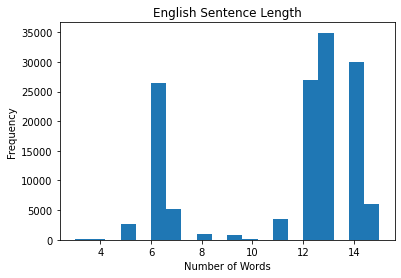

In [ ]:
import matplotlib.pyplot as plt
# Create a histogram of English sentence lengths
plt.hist(df['ENG Length'], bins=20)
plt.title('English Sentence Length')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

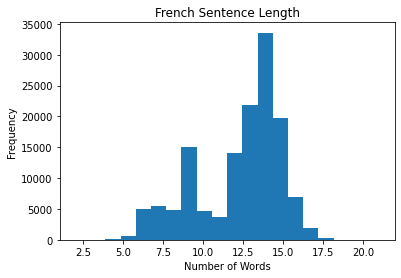

In [ ]:
# Create a histogram of French sentence lengths
plt.hist(df['FR Length'], bins=20)
plt.title('French Sentence Length')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

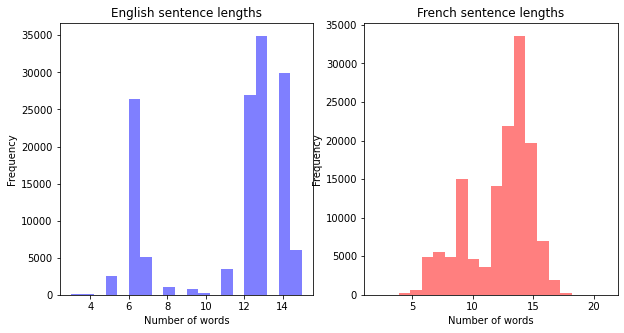

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the distribution of English sentence lengths
ax1.hist(df['ENG Length'], bins=20, color='blue', alpha=0.5)
ax1.set_title('English sentence lengths')
ax1.set_xlabel('Number of words')
ax1.set_ylabel('Frequency')

# Plot the distribution of French sentence lengths
ax2.hist(df['FR Length'], bins=20, color='red', alpha=0.5)
ax2.set_title('French sentence lengths')
ax2.set_xlabel('Number of words')
ax2.set_ylabel('Frequency')

# Show the plot
plt.show()

Get the maximum length of an english sentence and the maximum length of a french sentence. 

In [ ]:
eng_max_length = df['ENG Length'].max()
fr_max_length = df['FR Length'].max()

print("Maximum length of an English sentence:", eng_max_length)
print("Maximum length of a French sentence:", fr_max_length)

Maximum length of an English sentence: 15
Maximum length of a French sentence: 21


##Preprocessing the Data

In order for the data to be fed to the model, it has to be tokenized and padded. 

####Tokenization

**To tokenize english and french sentences, we can use only one tokenizer. True or False?**

False. English and French have different grammatical rules, so they require different tokenization methods. It's best to use separate tokenizers for each language.

Tokenize the sentences that we have.

In [ ]:
# Download the necessary tokenizer from nltk
nltk.download('punkt')

# Tokenize English sentences
english_sentences = df['English'].values.tolist()
tokenized_english = [nltk.word_tokenize(sent) for sent in english_sentences]

# Tokenize French sentences
french_sentences = df['French'].values.tolist()
tokenized_french = [nltk.word_tokenize(sent) for sent in french_sentences]

# Print the first 5 tokenized English sentences
print("Tokenized English sentences:")
for i in range(5):
    print(tokenized_english[i])

# Print the first 5 tokenized French sentences
print("\nTokenized French sentences:")
for i in range(5):
    print(tokenized_french[i])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Tokenized English sentences:
['the', 'united', 'states', 'is', 'usually', 'chilly', 'during', 'july', 'and', 'it', 'is', 'usually', 'freezing', 'in', 'november']
['california', 'is', 'usually', 'quiet', 'during', 'march', 'and', 'it', 'is', 'usually', 'hot', 'in', 'june']
['the', 'united', 'states', 'is', 'sometimes', 'mild', 'during', 'june', 'and', 'it', 'is', 'cold', 'in', 'september']
['your', 'least', 'liked', 'fruit', 'is', 'the', 'grape', 'but', 'my', 'least', 'liked', 'is', 'the', 'apple']
['his', 'favorite', 'fruit', 'is', 'the', 'orange', 'but', 'my', 'favorite', 'is', 'the', 'grape']

Tokenized French sentences:
['les', 'étatsunis', 'est', 'généralement', 'froid', 'en', 'juillet', 'et', 'il', 'gèle', 'habituellement', 'en', 'novembre']
['california', 'est', 'généralement', 'calme', 'en', 'mars', 'et', 'il', 'est', 'généralement', 'chaud', 'en', 'juin']
['les', 'étatsunis', 'est', 'parfois', 'légère', 'en', 'juin', 'et', 'il', 'fait', 'froid', 'en', 'septembre']
['votre', 'mo

**How many unique words do we have in english and in french?**

In [ ]:
# Get unique words in English and French
english_words = set(word for sentence in df["English"] for word in sentence.split())
french_words = set(word for sentence in df["French"] for word in sentence.split())

# Get the number of unique words
num_unique_english_words = len(english_words)
num_unique_french_words = len(french_words)

# Print the number of unique words
print("Number of unique words in English: ", num_unique_english_words)
print("Number of unique words in French: ", num_unique_french_words)


Number of unique words in English:  199
Number of unique words in French:  345


####Padding

**What should be the length of the sequences that we have after padding?**

The length of the sequences after padding should be equal to the length of the longest sentence in the dataset.

Perform padding on the sequences that we have.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_length = 20
# Create a tokenizer object
tokenizer = Tokenizer()

# Fit tokenizer on English sentences
tokenizer.fit_on_texts(df["English"])
tokenizer.word_index['start'] = len(tokenizer.word_index) + 1
tokenizer.word_index['end'] = len(tokenizer.word_index) + 2

# Convert English sentences to sequences of integers
X_sequences = tokenizer.texts_to_sequences(df["English"])

# Perform padding on English sequences
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding='post')

# Convert the French sentences to sequences of integers
y_sequences = tokenizer.texts_to_sequences(df["French"])

# Perform padding on French sequences
y_padded = pad_sequences(y_sequences, maxlen=max_length, padding='post')

print(X_padded)
print("-------------------")
print(y_padded)

print(X_padded.shape)
print(y_padded.shape)


[[ 5 20 21 ...  0  0  0]
 [22  1  9 ...  0  0  0]
 [ 5 20 21 ...  0  0  0]
 ...
 [19  1 10 ...  0  0  0]
 [24  1 10 ...  0  0  0]
 [ 5 84  1 ...  0  0  0]]
-------------------
[[ 0  0  0 ...  0  0  0]
 [22  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [24  0  0 ...  0  0  0]
 [13  0  0 ...  0  0  0]]
(137859, 20)
(137859, 20)


##Modeling

After preprrocessing the data, we can build our model. Start by building a baseline architecture relying on one directional RNNs, LSTMs, or GRUs. It will be good to lookup how to build Seq2Seq models, there are some new layers that will help you like RepeatVector and TimeDistributed.

In [ ]:
max_decoder_seq_length = len(y_padded[0]) 
for seq in y_padded:
    if len(seq) > max_decoder_seq_length:
        max_decoder_seq_length = len(seq) 

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense

max_encoder_seq_length = X_padded.shape[1]
num_encoder_tokens = len(tokenizer.word_index) + 1  # add 1 for padding token
num_decoder_tokens = len(tokenizer.word_index) + 1

latent_dim = 256  # number of dimensions in embedding space

encoder_inputs = Input(shape=(max_encoder_seq_length,))
encoder_embedding = Embedding(num_encoder_tokens, latent_dim, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_decoder_seq_length ,))
decoder_embedding = Embedding(num_decoder_tokens, latent_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_dense)
print(len(tokenizer.word_index))


201


Compile and train the model. 
**FYI:** While specifying the architecture of your model and the number of epochs for training, keeep in your mind that your model might take A LOT of time to train.

In [ ]:
# Compile the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# Train the model for 100 epochs

model.fit([X_padded[:, :max_length], y_padded[:, :max_length]], y_padded[:, :max_length], batch_size=64, epochs=50, validation_split=0.2)



Epoch 1/50
1724/1724 [==============================] - 704s 403ms/step - loss: 0.0742 - val_loss: 0.0027
Epoch 2/50
1724/1724 [==============================] - 656s 381ms/step - loss: 0.0011 - val_loss: 2.9529e-04
Epoch 3/50
1724/1724 [==============================] - 639s 370ms/step - loss: 1.9207e-04 - val_loss: 9.2261e-05
Epoch 4/50
1724/1724 [==============================] - 740s 429ms/step - loss: 7.3433e-05 - val_loss: 4.5739e-05
Epoch 5/50
1724/1724 [==============================] - 726s 421ms/step - loss: 3.0302e-05 - val_loss: 3.1626e-05
Epoch 6/50
1724/1724 [==============================] - 692s 401ms/step - loss: 1.9799e-05 - val_loss: 2.6112e-05
Epoch 7/50
1724/1724 [==============================] - 641s 372ms/step - loss: 1.4118e-05 - val_loss: 2.1952e-05
Epoch 8/50
1724/1724 [==============================] - 638s 370ms/step - loss: 1.1538e-05 - val_loss: 3.1879e-05
Epoch 9/50
1724/1724 [==============================] - 633s 367ms/step - loss: 9.6470e-06 - val_los

Define a function that gets an input sentence in english and gives the output sentence in the french language.

In [ ]:
def translate_to_french(input_sentence):
    # Tokenize and pad the input sentence
    input_sequence = tokenizer.texts_to_sequences([input_sentence])
    input_padded = pad_sequences(input_sequence, maxlen=max_length, padding='post')

    # Initialize the decoder sequence with a start token
    decoder_input_sequence = [[tokenizer.word_index['start']]]
    decoder_padded = pad_sequences(decoder_input_sequence, maxlen=max_decoder_seq_length, padding='post')

    # Predict the next word until the end token is reached or the maximum length is exceeded
    end_token_index = tokenizer.word_index['end']
    french_translation = ''
    while True:
        output_tokens = model.predict([input_padded, decoder_padded])
        output_index = np.argmax(output_tokens[0, -1, :])

        # Stop if end token is reached or the maximum length is exceeded
        if output_index == end_token_index or len(french_translation.split()) >= max_decoder_seq_length:
            break

        # Add the predicted word to the translation
        french_translation += tokenizer.index_word[output_index] + ' '

        # Update the decoder sequence with the predicted word
        decoder_input_sequence[0].append(output_index)
        decoder_padded = pad_sequences(decoder_input_sequence, maxlen=max_decoder_seq_length, padding='post')

    return french_translation


Test the following sentence

In [ ]:
input_sentence = "she is driving the truck"
french_translation = translate_to_french(input_sentence)
print(french_translation)

1/1 [==============================] - 0s 55ms/step
it been been been mango mango mango red jersey our december december december december blue eiffel cat visit apple paris 


Try to improve your model by modifying the architecture to take into account bidirectionality which is very useful in Machine Translation. Create a new model called model2

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Embedding, Dense, Concatenate
from tensorflow.keras.layers import Bidirectional
# Encoder
encoder_inputs = Input(shape=(max_encoder_seq_length,))
encoder_embedding = Embedding(num_encoder_tokens, latent_dim, mask_zero=True)(encoder_inputs)
encoder_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_embedding)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_decoder_seq_length,))
decoder_embedding = Embedding(num_decoder_tokens, latent_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')(decoder_outputs)

# Define the model
model2 = Model([encoder_inputs, decoder_inputs], decoder_dense)



compile and train your new model.

Define a new function that relies on your new model to make predictions.

In [ ]:
model2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
model2.fit([X_padded[:, :max_length], y_padded[:, :max_length]], y_padded[:, :max_length], batch_size=64, epochs=20, validation_split=0.2)

In [ ]:
def translate_to_french_v2(input_sentence):
    # Tokenize and pad the input sentence
    input_sequence = tokenizer.texts_to_sequences([input_sentence])
    input_padded = pad_sequences(input_sequence, maxlen=max_length, padding='post')

    # Initialize the decoder sequence with a start token
    decoder_input_sequence = [[tokenizer.word_index['start']]]
    decoder_padded = pad_sequences(decoder_input_sequence, maxlen=max_decoder_seq_length, padding='post')

    # Predict the next word until the end token is reached or the maximum length is exceeded
    end_token_index = tokenizer.word_index['end']
    french_translation = ''
    while True:
        output_tokens = model2.predict([input_padded, decoder_padded])
        output_index = np.argmax(output_tokens[0, -1, :])

        # Stop if end token is reached or the maximum length is exceeded
        if output_index == end_token_index or len(french_translation.split()) >= max_decoder_seq_length:
            break

        # Add the predicted word to the translation
        french_translation += tokenizer.index_word[output_index] + ' '

        # Update the decoder sequence with the predicted word
        decoder_input_sequence[0].append(output_index)
        decoder_padded = pad_sequences(decoder_input_sequence, maxlen=max_decoder_seq_length, padding='post')

    return french_translation


In [ ]:
input_sentence = "she is driving the truck"
french_translation = translate_to_french_v2(input_sentence)
print(french_translation)

**What is another adjustment in terms of architecture that you might be able to do to improve your model?**

attention mechanism. Attention allows the model to focus on the most relevant parts of the input sequence when generating each word of the output sequence. This can improve the accuracy of the model by ensuring that it considers the most important information when making predictions.

**What are some additional ways that we can do to improve the performance of our model?**

More training data: One of the most effective ways to improve the performance of a language translation model is to train it on more data. This can help the model to learn a wider range of language patterns and nuances, which can improve its accuracy.

Data augmentation: Another way to increase the amount of training data is to augment the existing data with variations of the same data. For example, you can add noise to the input data, translate the data to other languages, or paraphrase the sentences.

Model architecture: Adjusting the model architecture can also improve the performance of the model. For example, you can try using a different number of layers or different types of layers (e.g., convolutional layers, attention layers, etc.), or adjust the number of neurons in each layer.

Regularization: Regularization techniques can be used to prevent overfitting, which occurs when the model is too complex and learns the training data too well. Regularization techniques include L1, L2, and dropout regularization.

Pre-trained models: Pre-trained models can be used to improve the performance of a language translation model. For example, you can use a pre-trained language model as an encoder, and fine-tune it on your specific translation task.

Beam search: Beam search is a search algorithm used in natural language processing to find the most likely sequence of words. By using beam search, you can improve the quality of the output of the model, at the expense of computational cost.

Ensembling: Ensembling involves combining the predictions of multiple models to improve the overall performance. This can be done by training multiple models with different architectures or on different subsets of the data, and then averaging their predictions.